In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from tqdm import tqdm

from dare import Riccati
from data_gen import generate_simulated_data
from device import device
from env_setup import *
from models import ThetaEstimatorMLP

In [3]:
# Generate trajectories to train estimator
sim_policy = dict()
sim_policy['human_state'] = 'fixed'  # can be 'fixed' or 'varying'
sim_policy['mental_state'] = 'fixed'  # can be 'fixed' or 'varying'

sim_time = 20
n_demo = 1
human_mode = 'gradient_descent'  # can also be 'gradient_descent_threshold'

data = generate_simulated_data(sim_policy, sim_time, n_demo, human_mode)
robot_states, human_actions, human_obs, human_mental_states = data

100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


### Visualize the simulated human trajectory

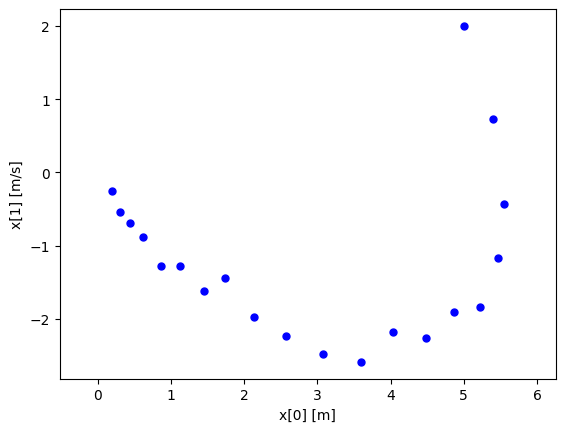

The robot starts at 0.4 m with 0 speed. Its goal is to achieve [0;0]. Note that the robot decelerates first, then accelerates


In [4]:
#@title Visualize the simulated human trajectory
human_traj = np.array(robot_states[0]).squeeze()
plt.plot(human_traj[:,0],human_traj[:,1],'bo', markersize=5)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.axis('equal')
plt.xlabel('x[0] [m]')
plt.ylabel('x[1] [m/s]')
plt.show()
print('The robot starts at 0.4 m with 0 speed. Its goal is to achieve [0;0]. \
Note that the robot decelerates first, then accelerates')

### Visualize the simulated human internal model

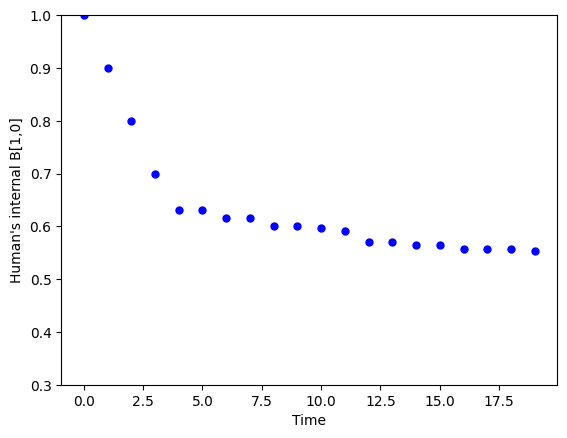

Note that here human's estination of B[1,0] starts from 1.0, then slowly approaches to the correct value (0.5).


In [5]:
#@title Visualize the simulated human internal model
human_internal_state_traj = np.array(human_mental_states[0]).squeeze()
plt.plot(human_internal_state_traj, 'bo', markersize=5)
plt.ylim([0.3, 1.0])
plt.xlabel('Time')
plt.ylabel('Human\'s internal B[1,0]')
plt.show()
print('Note that here human\'s estination of B[1,0] starts from 1.0, then slowly approaches to the correct value (0.5).')

### Pre-processing trajectory data for estimator

In [6]:
# Assemble data into matrix
states = [s[0].T for s in robot_states[0]]
states = np.concatenate(states)

actions = [a[0].T for a in human_actions[0]]
actions = np.concatenate(actions)

mental_states = [s[0].T for s in human_mental_states[0]]
mental_states = np.concatenate(mental_states)
mental_states = torch.tensor(mental_states).to(device)

sa_tuples = np.concatenate((states, actions), axis=1)

# Create normalizer
scaler = StandardScaler()
scaler.fit(sa_tuples)
norm_sa_tuples = scaler.transform(sa_tuples)

# Put inputs into tensors
sa_tuples = torch.tensor(sa_tuples).to(device)
norm_sa_tuples = torch.tensor(norm_sa_tuples).to(device)
states = sa_tuples[:, :2]
actions = sa_tuples[:, 2:]
norm_states = norm_sa_tuples[:, :2]
norm_actions = norm_sa_tuples[:, 2:]

N = states.shape[0]
print(N)

20


### Train $\theta_H$ estimator E2E with LQR

In [7]:
EPOCHS = 100
theta_H_estimator = ThetaEstimatorMLP().to(device).double()
theta_H_estimator.train()
optimizer = torch.optim.Adam(theta_H_estimator.parameters(), lr=0.1)

In [8]:
def predict_action(state, theta_H):
    B_hat_tensor = theta_H * torch.tensor([[0., ],[1.0]], device = device).double()
    P_hat = Riccati.apply(A_tensor, B_hat_tensor, Q_tensor, R_tensor)

    K = torch.linalg.multi_dot((
        torch.linalg.pinv(torch.add(
            R_tensor,
            torch.linalg.multi_dot((torch.transpose(B_hat_tensor, 0, 1), P_hat, B_hat_tensor))
        )),
        torch.transpose(B_hat_tensor, 0, 1),
        P_hat,
        A_tensor
    ))
    action_pred = torch.neg(torch.matmul(K, state))
    return action_pred

def mlp_step(state, action, norm_state, norm_action):
    input = torch.cat((norm_state, norm_action)).reshape(-1)
    theta_H = theta_H_estimator(input)
    # theta_H = torch.clamp(theta_H_estimator(input), min=0.001, max=1.0)
    action_pred = predict_action(state, theta_H)

    optimizer.zero_grad()
    loss_fn = nn.MSELoss()
    loss = loss_fn(action_pred, action)
    loss.backward()
    optimizer.step()

    # action_dist = torch.norm(action_pred - action)
    # print('Epoch: Loss={}, theta_H={}, action_pred={}, action={}, action_dist={}'.format(loss.data.item(), theta_H.data.item(), action_pred.data.item(), action.data.item(), action_dist.data.item()))
    # print('Epoch: Loss={}, theta_H={}'.format(loss.data.item(), theta_H.data.item()))

    return loss.data.item(), theta_H.data.item()

100%|██████████| 100/100 [00:01<00:00, 56.32it/s]


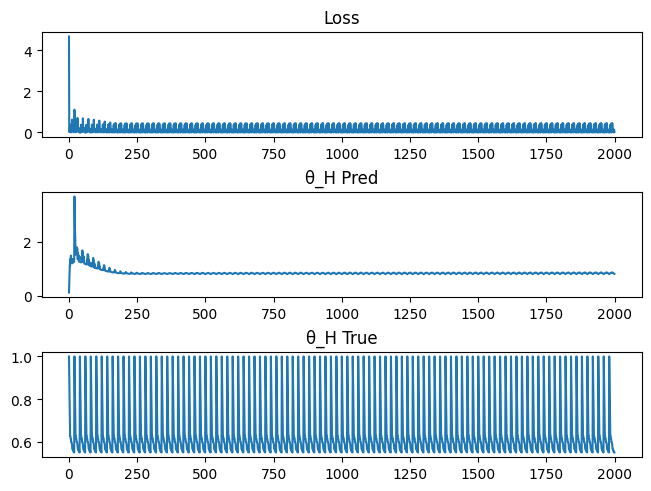

In [9]:
loss_list, theta_H_list, theta_H_true_list = [], [], []
for epoch in tqdm(range(EPOCHS)):
    for idx in range(N):
        # idx = randrange(N)
        # idx = 0
        state, action, mental_state = states[idx], actions[idx], mental_states[idx]
        norm_state, norm_action = norm_states[idx], norm_actions[idx]
        loss, theta_H = mlp_step(state, action, norm_state, norm_action)
        loss_list.append(loss)
        theta_H_list.append(theta_H)
        theta_H_true_list.append(mental_state.data.item())
    # print('Epoch {}: Loss={}, theta_H={}'.format(epoch, loss, theta_H))

fig, axs = plt.subplots(3, constrained_layout=True)
axs[0].plot(range(EPOCHS * N), loss_list)
axs[1].plot(range(EPOCHS * N), theta_H_list)
axs[2].plot(range(EPOCHS * N), theta_H_true_list)
axs[0].title.set_text('Loss')
axs[1].title.set_text('θ_H Pred')
axs[2].title.set_text('θ_H True')